In [1]:
pip install -q keras-nlp

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow import keras
import keras_nlp
import matplotlib.pyplot as plt

2024-05-05 08:36:23.476685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 08:36:23.476813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 08:36:23.634080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [3]:
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_train.csv')

df['humour'] = df['humour'].replace({'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious' : 1})
df['sarcastic'] = df['sarcastic'].replace({'not_sarcastic': 0, 'twisted_meaning': 1, 'general' : 1, 'little_sarcastic' : 1, 'very_sarcastic' : 1, 'very_twisted' : 1})
df['offensive'] = df['offensive'].replace({'not_offensive': 0, 'offensive': 1, 'slight' : 1, 'very_offensive' : 1, 'hateful_offensive': 1})
df['motivational'] = df['motivational'].replace({'not_motivational': 0, 'motivational': 1})

for index, row in df.iterrows():
    if pd.isna(row['ocr']):
        df.drop(index, inplace=True)

X_train = df['ocr']
#changing into list
X_train = X_train.tolist()
X_train = [s.replace('\n', ' ') for s in X_train]

# Combine the columns into a new DataFrame
Y_train = pd.concat([df['humour'], df['sarcastic'], df['offensive'], df['motivational']], axis=1)
Y_train = np.array(Y_train, dtype=np.int32)

/tmp/ipykernel_34/4201297922.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['humour'] = df['humour'].replace({'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious' : 1})
/tmp/ipykernel_34/4201297922.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sarcastic'] = df['sarcastic'].replace({'not_sarcastic': 0, 'twisted_meaning': 1, 'general' : 1, 'little_sarcastic' : 1, 'very_sarcastic' : 1, 'very_twisted' : 1})
/tmp/ipykernel_34/4201297922.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

In [4]:
Y_train.shape

(7000, 4)

In [5]:
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_val.csv')

df['humour'] = df['humour'].replace({'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious' : 1})
df['sarcastic'] = df['sarcastic'].replace({'not_sarcastic': 0, 'twisted_meaning': 1, 'general' : 1, 'little_sarcastic' : 1, 'very_sarcastic' : 1, 'very_twisted' : 1})
df['offensive'] = df['offensive'].replace({'not_offensive': 0, 'offensive': 1, 'slight' : 1, 'very_offensive' : 1, 'hateful_offensive': 1})
df['motivational'] = df['motivational'].replace({'not_motivational': 0, 'motivational': 1})

#iterating over the dataframe if ocr is null drop the frame
for index, row in df.iterrows():
    if pd.isna(row['ocr']):
        df.drop(index, inplace=True)

X_val = df['ocr']
#changing into list
X_val = X_val.tolist()
X_val = [s.replace('\n', ' ') for s in X_val]

# Combine the columns into a new DataFrame
Y_val = pd.concat([df['humour'], df['sarcastic'], df['offensive'], df['motivational']], axis=1)
Y_val = np.array(Y_val, dtype=np.int32)

/tmp/ipykernel_34/2455014672.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['humour'] = df['humour'].replace({'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious' : 1})
/tmp/ipykernel_34/2455014672.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sarcastic'] = df['sarcastic'].replace({'not_sarcastic': 0, 'twisted_meaning': 1, 'general' : 1, 'little_sarcastic' : 1, 'very_sarcastic' : 1, 'very_twisted' : 1})
/tmp/ipykernel_34/2455014672.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will 

In [6]:
Y_val.shape

(1481, 4)

In [11]:
# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_multi",
    sequence_length=128,
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_multi",
    num_classes=4,  # Adjust num_classes to match the number of labels
    preprocessor=preprocessor,
)

# Adjust the model's output layer for multi-label classification
classifier.layers[-1].activation = keras.activations.sigmoid

# Compile the model with suitable loss and metrics for multi-label classification
classifier.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(5e-5),
    metrics=['accuracy'],
    jit_compile=True,
)

# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False

# Fit the model
classifier.fit(x=X_train, y=Y_train, epochs=25, batch_size=32, validation_data=(X_val, Y_val))

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_multi/2' to your Kaggle notebook...


Epoch 1/25


W0000 00:00:1714898797.211902     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


218/219 [============================>.] - ETA: 0s - loss: 0.4964 - accuracy: 0.8415

W0000 00:00:1714898888.525016     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/219 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.8417

W0000 00:00:1714898892.951813     180 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/219 [==============================] - 128s 468ms/step - loss: 0.4966 - accuracy: 0.8417 - val_loss: 0.3941 - val_accuracy: 0.9392


W0000 00:00:1714898899.610526     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/25
219/219 [==============================] - 85s 387ms/step - loss: 0.4828 - accuracy: 0.7830 - val_loss: 0.4033 - val_accuracy: 0.9136
Epoch 3/25
219/219 [==============================] - 87s 399ms/step - loss: 0.4573 - accuracy: 0.7231 - val_loss: 0.4487 - val_accuracy: 0.8758
Epoch 4/25
219/219 [==============================] - 89s 406ms/step - loss: 0.4207 - accuracy: 0.7029 - val_loss: 0.4780 - val_accuracy: 0.8690
Epoch 5/25
219/219 [==============================] - 89s 407ms/step - loss: 0.3788 - accuracy: 0.7014 - val_loss: 0.5768 - val_accuracy: 0.8980
Epoch 6/25
219/219 [==============================] - 89s 407ms/step - loss: 0.3400 - accuracy: 0.7100 - val_loss: 0.5662 - val_accuracy: 0.8947
Epoch 7/25
219/219 [==============================] - 89s 407ms/step - loss: 0.3010 - accuracy: 0.7166 - val_loss: 0.5370 - val_accuracy: 0.6880
Epoch 8/25
219/219 [==============================] - 89s 407ms/step - loss: 0.2507 - accuracy: 0.7404 - val_loss: 0.6362 - val_ac

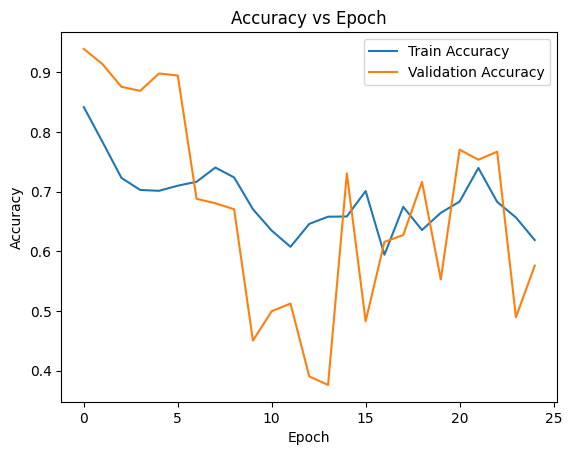

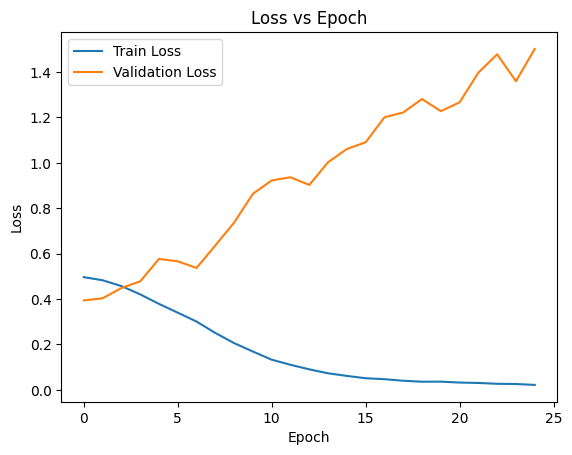

In [12]:
# Plot accuracy vs epoch
plt.plot(classifier.history.history['accuracy'], label='Train Accuracy')
plt.plot(classifier.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss vs epoch
plt.plot(classifier.history.history['loss'], label='Train Loss')
plt.plot(classifier.history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
predicted = classifier.predict(X_val)

 2/47 [>.............................] - ETA: 6s  

W0000 00:00:1714901322.392694     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 [==============================] - 9s 130ms/step


W0000 00:00:1714901328.363189     181 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [16]:
predicted[:5]

array([[0, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 0, 0],
       [1, 1, 1, 0],
       [1, 1, 1, 0]])

In [15]:
# Threshold value for considering a class as present
threshold = 0.5

# Convert predicted probabilities to binary array
predicted = (predicted > threshold).astype(int)

In [17]:
accuracy_arr = []
f1_arr = []
precision_arr = []
recall_arr = []

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluate accuracy
humour_accuracy = accuracy_score(Y_val[:,0], predicted[:,0])

# Calculate F1 score
humour_f1 = f1_score(Y_val[:,0], predicted[:,0], average='weighted')

# Calculate precision
humour_precision = precision_score(Y_val[:,0], predicted[:,0], average='weighted')

# Calculate recall
humour_recall = recall_score(Y_val[:,0], predicted[:,0], average='weighted')

accuracy_arr.append(humour_accuracy)
f1_arr.append(humour_f1)
precision_arr.append(humour_precision)
recall_arr.append(humour_recall)

print("Score of Humour Detection")
print("Accuracy:", humour_accuracy)
print("F1 Score:", humour_f1)
print("Precision:", humour_precision)
print("Recall:", humour_recall)

Score of Humour Detection
Accuracy: 0.8548278190411884
F1 Score: 0.865940098046731
Precision: 0.8776957763569244
Recall: 0.8548278190411884


In [19]:
# Evaluate accuracy
sarcasm_accuracy = accuracy_score(Y_val[:,1], predicted[:,1])

# Calculate F1 score
sarcasm_f1 = f1_score(Y_val[:,1], predicted[:,1], average='weighted')

# Calculate precision
sarcasm_precision = precision_score(Y_val[:,1], predicted[:,1], average='weighted')

# Calculate recall
sarcasm_recall = recall_score(Y_val[:,1], predicted[:,1], average='weighted')

accuracy_arr.append(sarcasm_accuracy)
f1_arr.append(sarcasm_f1)
precision_arr.append(sarcasm_precision)
recall_arr.append(sarcasm_recall)

print("Score of Sarcasm Detection")
print("Accuracy:", sarcasm_accuracy)
print("F1 Score:", sarcasm_f1)
print("Precision:", sarcasm_precision)
print("Recall:", sarcasm_recall)

Score of Sarcasm Detection
Accuracy: 0.8143146522619852
F1 Score: 0.832233811714529
Precision: 0.8520476208714886
Recall: 0.8143146522619852


In [20]:
# Evaluate accuracy
offensive_accuracy = accuracy_score(Y_val[:,2], predicted[:,2])

# Calculate F1 score
offensive_f1 = f1_score(Y_val[:,2], predicted[:,2], average='weighted')

# Calculate precision
offensive_precision = precision_score(Y_val[:,2], predicted[:,2], average='weighted')

# Calculate recall
offensive_recall = recall_score(Y_val[:,2], predicted[:,2], average='weighted')

accuracy_arr.append(offensive_accuracy)
f1_arr.append(offensive_f1)
precision_arr.append(offensive_precision)
recall_arr.append(offensive_recall)

print("Score of Offensive Detection")
print("Accuracy:", offensive_accuracy)
print("F1 Score:", offensive_f1)
print("Precision:", offensive_precision)
print("Recall:", offensive_recall)

Score of Offensive Detection
Accuracy: 0.47805536799459825
F1 Score: 0.4788907509171567
Precision: 0.4965658072724013
Recall: 0.47805536799459825


In [21]:
# Evaluate accuracy
motivation_accuracy = accuracy_score(Y_val[:,3], predicted[:,3])

# Calculate F1 score
motivation_f1 = f1_score(Y_val[:,3], predicted[:,3], average='weighted')

# Calculate precision
motivation_precision = precision_score(Y_val[:,3], predicted[:,3], average='weighted')

# Calculate recall
motivation_recall = recall_score(Y_val[:,3], predicted[:,3], average='weighted')

accuracy_arr.append(motivation_accuracy)
f1_arr.append(motivation_f1)
precision_arr.append(motivation_precision)
recall_arr.append(motivation_recall)

print("Score of Motivation Detection")
print("Accuracy:", motivation_accuracy)
print("F1 Score:", motivation_f1)
print("Precision:", motivation_precision)
print("Recall:", motivation_recall)

Score of Motivation Detection
Accuracy: 0.9189736664415935
F1 Score: 0.9326510418363153
Precision: 0.9474439839524889
Recall: 0.9189736664415935


In [22]:
accuracy_arr = np.array(accuracy_arr)
f1_arr = np.array(f1_arr)
precision_arr = np.array(precision_arr)
recall_arr = np.array(recall_arr)
print("Average scores :")
print("Avg accuracy:",np.mean(accuracy_arr))
print("Avg f1 score:",np.mean(f1_arr))
print("Avg precision",np.mean(precision_arr))
print("Avg recall:",np.mean(recall_arr))

Average scores :
Avg accuracy: 0.7665428764348414
Avg f1 score: 0.7774289256286829
Avg precision 0.7934382971133258
Avg recall: 0.7665428764348414
